<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Настройка-окружения" data-toc-modified-id="Настройка-окружения-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Настройка окружения</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Результаты-исследования" data-toc-modified-id="Результаты-исследования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Результаты исследования</a></span><ul class="toc-item"><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></li></ul></div>

# Определение возраста покупателей
<p>
<div align="right"><b>Спринт 14 | Когорта ДС13 | Артур Урусов</b></div>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Настройка окружения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

Первым делом загрузим данные. Сделаем это в два этапа: сначала загрузим датасет с предполагаемым возрастом и ссылкой на картинки, затем -  создадим генератор и авоспользуемся методом `flow_from_dataframe()` чтобы создать генератор с картинками и соответствующим возрастом.

In [2]:
# Сохраним датасет с предполагаемым возрастом и ссылкой на картинку в переменную labels
labels = pd.read_csv('/datasets/faces/labels.csv')

# Создадим генератор и с его помощью загрузим картинки и соответствующие отметки с возрастом в итератор train_gen_flow
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
)

Found 7591 validated image filenames.


Всего найдено 7591 изображение. Получим информацию о датафрейме:

In [3]:
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Количество строк и найденных ихображений совпадает, значит всё прошло гладко и ошибок при чтении данных не было. В датасете не присутствует никакой дополнительной информации, только название фотографии и возраст. Названия представляют собой только порядковый номер не отсортированный по возрасту, утечек данных не видно.

Теперь посмотрим на распределение возрастов в датасете:

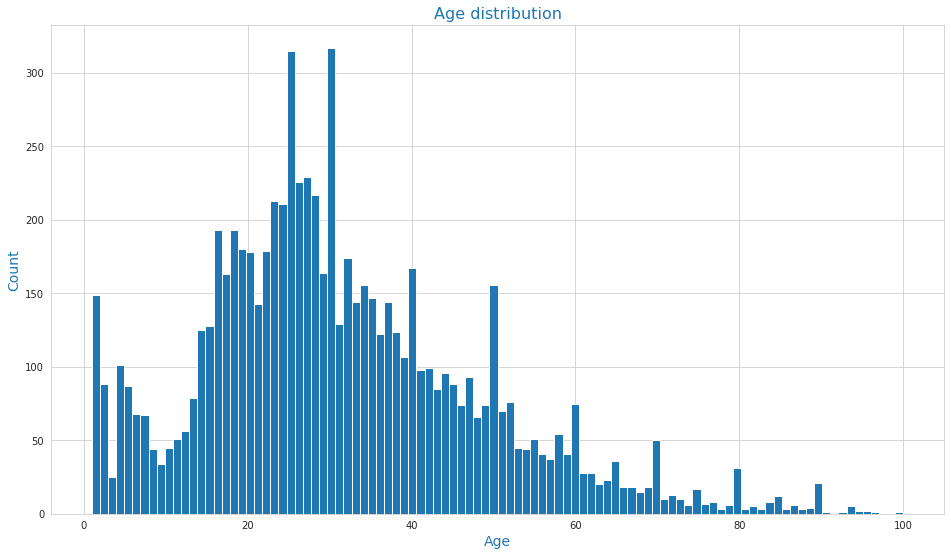

In [4]:
sns.set_style('whitegrid')
labels.hist(bins=100, figsize=(16,9))
plt.title('Age distribution', size=16, color='tab:blue')
plt.xlabel('Age', size=14, color='tab:blue')
plt.ylabel('Count', size=14, color='tab:blue')
plt.show()

Для правильного восприятия данных нужно понимать, откуда в датасете появился возраст. По информации из открытых источников датасет состоит из реальных данных о возрасте (где это возможно) перемешанных с данными голосования о предполагаемом возрасте человека на фотографии. То есть часть данных о возрасте реальные, а часть - попытка людей угадать возраст по фото. Всего было получено около 250,000 голосов, что в среднем даёт 38 голосов на каждое изображение.

График отдалённо похож на демографическую пирамиду (но без разделения на пол). Как видно из графика, большая часть данных приходится на людей в возрасте от 20 до 40 лет. С одной стороны, в этом промежутке можно ожидать более точное предсказание возраста, с другой - в этом промежутке может быть и большое количество человеческих ошибок. 

Начиная с сорока лет видим большие «шпили» каждые 10 лет - похоже на последствие тяги людей к круглым числам, да и психологически легче предположить условный десяток лет, а не конкретный возраст.

С детьми ситуация выглядит довольно хаотично.

Ниже представим набор из 16 фотографий из датасета с подписанным возрастом.

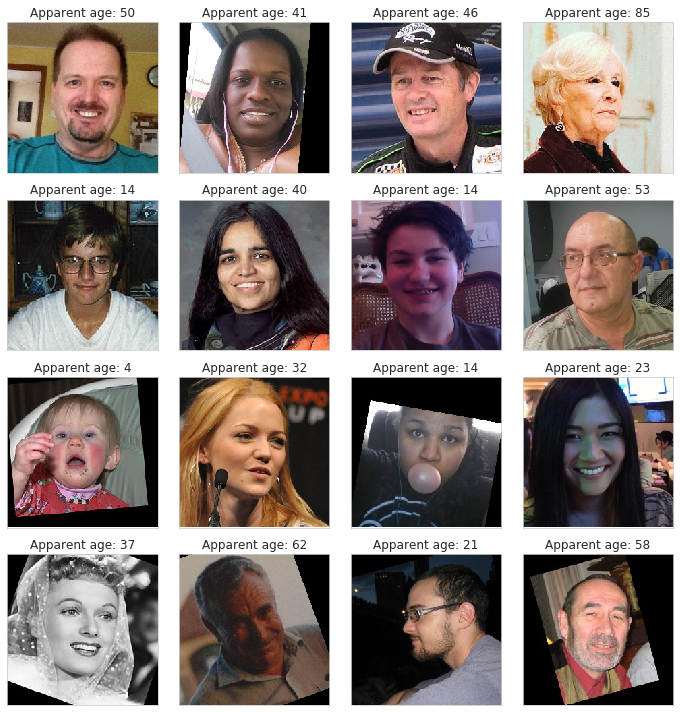

In [5]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Apparent age: {target[i]}')

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На этой небольшой выборке мы видим, что представленные фотографии отличаются своим разнообразием. Есть цветные и чёрно-белые, качественные и «мыльные», с разным положением лица и поворотом головы. Однако, можно отметить, что датасет предобработан - лица крупные и находятся в центре картинки, в некоторых случаях область вокруг лиц обрезана. Некоторые лица повернуты - или для аугментации, или попытка выровнять лицо на картинке. На глаз, угол поворота не превышает 45°. 

Применение аугментации возможно, но не факт, что пригодится - датасет довольно разнообразен. Допустимо применить повороты, увеличение, отзеркаливание. Растяжение, скорее всего не имеет смысла.

В целом, для большинства изображений возраст похож на правдивый, однако даже в такой маленькой выборке можно найти и спорные варианты.

## Обучение модели

Для предсказания возраста тестировалось некоторое количество моделей (около 120) с различными параметрами:

- с применением аугментации и без;
- с использованием предобученной на ImageNet модели ResNet50 и с обучением модели с нуля;
- с различной архитектурой «головной» части модели;
- с различными оптимизаторами (Adam и SGD);
- с различными значениями learning rate;
- с функциями потерь MSE и MAE;
- с различным количеством эпох (от 5 до 20).

Однако, наилучших результатов добилась представленная ниже модель.

Параметры:
- без аугментации;
- с использованием предобученной на ImageNet модели ResNet50;
- с простой «головой», настроенной на задачу регрессии и активатором ReLU;
- с оптимизатором Adam;
- с learning rate 0.00015;
- с функцией потерь MSE;
- с количеством эпох равным 15.

```python
'''Section 1. Importing libs and modules'''
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


'''Section 2. Defining functions'''
def load_train(path, batch_size=32):
    '''Loads train dataset and returns a DataFrameIterator'''
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=.25,
        rescale=1/255.
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_datagen_flow


def load_test(path, batch_size=32):
    '''Loads test dataset and returns a DataFrameIterator'''
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=.25,
        rescale=1/255.,
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_datagen_flow


def create_model(input_shape):
    '''Creates a ResNet50 model with head customized for regression tasks'''
    # Creating backbone for model from headless ResNet50 model pretrained on ImageNet
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    # Combining backbone with custom head layers for regression tasks
    model = Sequential([
        backbone,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='relu')
    ])

    # Defining optimizer Adam with custom learning rate
    optimizer = Adam(
        lr=.00015
    )

    # Compiling the model
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model


def train_model(
        model,
        train_data,
        test_data,
        batch_size=None,
        epochs=20,
        steps_per_epoch=None,
        validation_steps=None,
        verbose=2
):
    '''Trains model on train data with validation on test data, prints test loss and test MAE'''
    model.fit(
        train_data,
        validation_data=test_data,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose
    )

    print('Evaluate on test data')
    results = model.evaluate(test_data, batch_size=batch_size)
    print(f'test loss: {results[0]}, test mae: {results[1]}')

    return model
```

После загрузки модели на сервер с GPU, прошла проверка модели и сервер вернул следующие данные:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/15
178/178 - 48s - loss: 205.1262 - mae: 10.2328 - val_loss: 661.9579 - val_mae: 20.7682
Epoch 2/15
178/178 - 39s - loss: 66.2899 - mae: 6.1770 - val_loss: 496.3826 - val_mae: 17.0600
Epoch 3/15
178/178 - 39s - loss: 33.1872 - mae: 4.4445 - val_loss: 261.7884 - val_mae: 12.1581
Epoch 4/15
178/178 - 39s - loss: 21.7558 - mae: 3.5682 - val_loss: 119.4206 - val_mae: 8.3937
Epoch 5/15
178/178 - 39s - loss: 15.4488 - mae: 3.0341 - val_loss: 83.7702 - val_mae: 6.8509
Epoch 6/15
178/178 - 39s - loss: 11.2420 - mae: 2.5863 - val_loss: 67.0283 - val_mae: 6.2028
Epoch 7/15
178/178 - 39s - loss: 8.5341 - mae: 2.2063 - val_loss: 74.2562 - val_mae: 6.7369
Epoch 8/15
178/178 - 39s - loss: 8.7710 - mae: 2.2261 - val_loss: 78.9709 - val_mae: 6.6297
Epoch 9/15
178/178 - 39s - loss: 8.5961 - mae: 2.1920 - val_loss: 72.6561 - val_mae: 6.1832
Epoch 10/15
178/178 - 39s - loss: 8.7232 - mae: 2.2462 - val_loss: 66.7952 - val_mae: 6.2614
Epoch 11/15
178/178 - 39s - loss: 7.2143 - mae: 2.0426 - val_loss: 75.5334 - val_mae: 6.6524
Epoch 12/15
178/178 - 39s - loss: 7.0450 - mae: 1.9929 - val_loss: 71.7762 - val_mae: 6.5744
Epoch 13/15
178/178 - 39s - loss: 6.7062 - mae: 1.9523 - val_loss: 71.4373 - val_mae: 6.3270
Epoch 14/15
178/178 - 39s - loss: 5.9006 - mae: 1.8314 - val_loss: 68.6082 - val_mae: 6.3699
Epoch 15/15
178/178 - 39s - loss: 5.1658 - mae: 1.7258 - val_loss: 64.4475 - val_mae: 5.9240

Evaluate on test data
test loss: 64.44749164581299, test mae: 5.923969268798828

Test MAE: 5.9240
```

Получился довольно неплохой результат. Ниже необходимых **8 MAE** и даже ниже «хороших» **7 MAE**. Немного не хватило до **5.4 MAE**, как у авторов [статьи](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), но в рамках этого исследования таких результатов достичь не удалось.

## Анализ обученной модели

Для анализа результатов модели перенесём значения в соответствующие numpy-массивы:

In [6]:
train_loss = np.array([
    205.1262, 66.2899, 33.1872, 21.7558, 15.4488, 
    11.2420, 8.5341, 8.7710, 8.5961, 8.7232, 
    7.2143, 7.0450, 6.7062, 5.9006, 5.1658
])
train_mae = np.array([
    10.2328, 6.1770, 4.4445, 3.5682, 3.0341, 
    2.5863, 2.2063, 2.2261, 2.1920, 2.2462, 
    2.0426, 1.9929, 1.9523, 1.8314, 1.7258
])
test_loss = np.array([
    661.9579, 496.3826, 261.7884, 119.4206, 83.7702, 
    67.0283, 74.2562, 78.9709, 72.6561, 66.7952, 
    75.5334, 71.7762, 71.4373, 68.6082, 64.4475
])
test_mae = np.array([
    20.7682, 17.0600, 12.1581, 8.3937, 6.8509, 
    6.2028, 6.7369, 6.6297, 6.1832, 6.2614, 
    6.6524, 6.5744, 6.3270, 6.3699, 5.9240
])

Построим график зависимости функции потерь от эпохи.

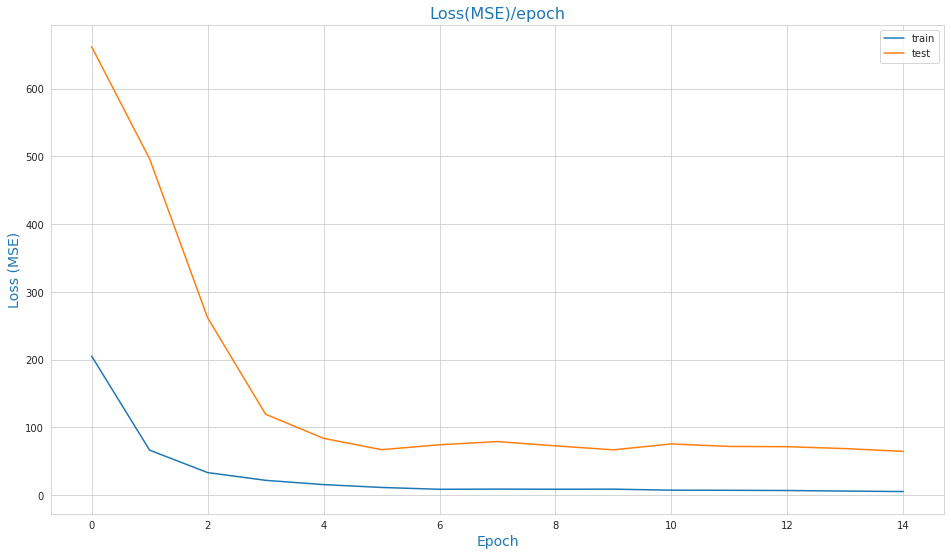

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,9))
plt.title('Loss(MSE)/epoch', size=16, color='tab:blue')
plt.xlabel('Epoch', size=14, color='tab:blue')
plt.ylabel('Loss (MSE)', size=14, color='tab:blue')
sns.lineplot(data=train_loss, label='train')
sns.lineplot(data=test_loss, label='test')
plt.show()

На графике видно, что на трейне после 4 эпохи значения функции потерь практически не меняются, но медленно снижаются. Для тестовой выборки ситуация несколько отличается - резкое падение значений функции потерь продолжалось до 5 эпохи, а затем значение колебалось в небольшом диапазоне значений, однако к концу смогло достичь своего минимума.

В целом поведение модели на тренировочной и тестовой выборке сходно, графики похожи, но разница между значениями довольно большая – скорее всего это связано с переобучением.

Теперь построим графики зависимости MAE от эпохи.

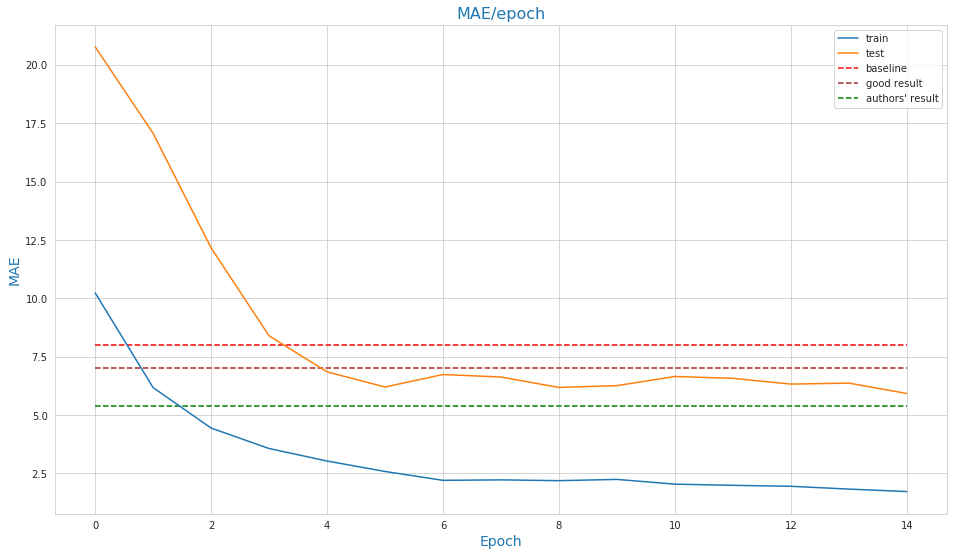

In [8]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,9))
plt.title('MAE/epoch', size=16, color='tab:blue')
plt.xlabel('Epoch', size=14, color='tab:blue')
plt.ylabel('MAE', size=14, color='tab:blue')
plt.hlines(8, 0, 14, colors='red', linestyles='dashed', label='baseline')
plt.hlines(7, 0, 14, colors='brown', linestyles='dashed', label='good result')
plt.hlines(5.4, 0, 14, colors='green', linestyles='dashed', label='authors\' result')
sns.lineplot(data=train_mae, label='train')
sns.lineplot(data=test_mae, label='test')
plt.show()

Здесь мы также отметили три значения целевого показателя:
- бейслайн: **8 MAE**;
- «хороший» результат: **7 MAE**;
- результат авторов [статьи](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf): **5.4 MAE**.

Модель на тренировочной выборке достаточно быстро преодолевает все три значения, и уже на второй эпохе опускается ниже **5 MAE**, а на 6 эпохе - ниже **2.5 MAE**.

На тренировочной выборке модель тоже довольно быстро снижает уровень ошибки: на 4 эпохе значение **MAE** уже вписывается в «хороший» уровень **ниже 7**. Однако, с 5 эпохи модель начинает колебаться и доходит до минимального значения в **5.9240** только на 15 эпохе. Можно сказать, что имеет место переобучение.

На этом графике более отчётливо видно, что после 5 эпохи модель начинает стагнировать и колебаться в условном корридоре между **7** и **5.4 MAE**. Вероятно, какая-то комбинация параметров сможет опуститть значение **MAE ниже 5.4**, однако, эта комбинация в рамках исследования не были найдена.

## Результаты исследования

### Общие выводы

В рамках проекта мы построили для супермаркета «Хлеб-Соль» модель, которая по фотографии определит приблизительный возраст человека. 

В нашем распоряжении был набор фотографий людей с указанием возраста - предобработанный датасет [APPA-REAL](http://chalearnlap.cvc.uab.es/dataset/26/description/).

Мы загрузили необходимые данные, провели предварительный анализ данных.

После этого мы начали подбирать параметры модели для предсказания возраста на фотографиях. Основой модели стала архетиктура ResNet (модель ResNet50), однако при подборе лучшей модели использовались разные значения параметров:
- с применением аугментации и без;
- с использованием предобученной на ImageNet модели ResNet50 и с обучением модели с нуля;
- с различной архитектурой «головной» части модели;
- с различными оптимизаторами (Adam и SGD);
- с различными значениями learning rate;
- с функциями потерь MSE и MAE;
- с различным количеством эпох (от 5 до 20).

Целевой показатель **MAE** состоял из трёх значений:
- бейслайн: **8 MAE**;
- «хороший» результат: **7 MAE**;
- результат авторов [статьи](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf): **5.4 MAE**.

Наилучшего показателя в **5.9240 MAE** достигла модель со следующими параметрами:
- без аугментации;
- с использованием предобученной на ImageNet модели ResNet50;
- с простой «головой», настроенной на задачу регрессии и активатором ReLU;
- с оптимизатором Adam;
- с learning rate 0.00015;
- с функцией потерь MSE;
- с количеством эпох равным 15.

Далее мы проанализировали процесс обучения модели. В целом, модель обучалась без больших проблем, но имело место некоторое переобучение – слишком большая разница между тренировочной выборкой и тестовой. Однако, всё ещё не найден наиболее качественный вариант, сравнимый по уровню ошибки с результатом авторов [статьи](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf): **5.4 MAE**.

Тем не менее, с точки зрения первоначальной задачи:
- анализ покупок и предложение товаров, которые могут заинтересовать покупателей этой возрастной группы;
- контроль добросовестности кассиров при продаже алкоголя;

значение **MAE в 5.9240** допустимо.

### Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы